In [ ]:
!pip install flask
!pip install prophet
!pip install pmdarima
!pip install fredapi
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 484.3 kB/s eta 0:00:00


In [ ]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import re
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
#FRED API key
api_key = 'cd4824b5340bd239112283f84d74e787'

# date range
start_date = '2014-01-01'
end_date = '2019-12-01'

# URL - Federal Funds Rate (Interest Rates)
interest_rate_url = f'https://api.stlouisfed.org/fred/series/observations?series_id=FEDFUNDS&api_key={api_key}&file_type=json'

# URL - CPI (Inflation Rates)
inflation_rate_url = f'https://api.stlouisfed.org/fred/series/observations?series_id=CPIAUCSL&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}'

# Function to fetch data from FRED API
def fetch_fred_data(url):
    response = requests.get(url)
    data = response.json()['observations']
    return pd.DataFrame(data)

# Fetching interest rate and inflation rate data
interest_rate_data = fetch_fred_data(interest_rate_url)
inflation_rate_data = fetch_fred_data(inflation_rate_url)

# first few rows of each
print(interest_rate_data.head())
print(inflation_rate_data.head())

# Converting the 'date' columns to datetime format
interest_rate_data['date'] = pd.to_datetime(interest_rate_data['date'])
inflation_rate_data['date'] = pd.to_datetime(inflation_rate_data['date'])

# Renaming the 'value' columns for clarity
interest_rate_data.rename(columns={'value': 'fed_funds_rate'}, inplace=True)
inflation_rate_data.rename(columns={'value': 'cpi'}, inplace=True)

# Convert the 'value' columns to numeric
interest_rate_data['fed_funds_rate'] = pd.to_numeric(interest_rate_data['fed_funds_rate'])
inflation_rate_data['cpi'] = pd.to_numeric(inflation_rate_data['cpi'])

# Merge the two datasets on the 'date' column
macro_data = pd.merge(interest_rate_data[['date', 'fed_funds_rate']],
                      inflation_rate_data[['date', 'cpi']],
                      on='date',
                      how='inner')

# Display the merged dataset
print(macro_data.head())

# data file
df = macro_data

#  Ensuring the column with percentage is string type
df['cpi'] = df['cpi'].astype(str)

#  Remove '%' and convert to numeric
df['cpi'] = pd.to_numeric(df['cpi'].str.replace('%', ''), errors='coerce')

# convert percentage to decimal (e.g., 50% -> 0.50)
df['cpi'] = df['cpi'] / 100

print(df)
print (macro_data.head())


  realtime_start realtime_end        date value
0     2024-10-01   2024-10-01  1954-07-01  0.80
1     2024-10-01   2024-10-01  1954-08-01  1.22
2     2024-10-01   2024-10-01  1954-09-01  1.07
3     2024-10-01   2024-10-01  1954-10-01  0.85
4     2024-10-01   2024-10-01  1954-11-01  0.83
  realtime_start realtime_end        date    value
0     2024-10-15   2024-10-15  2014-01-01  235.288
1     2024-10-15   2024-10-15  2014-02-01  235.547
2     2024-10-15   2024-10-15  2014-03-01  236.028
3     2024-10-15   2024-10-15  2014-04-01  236.468
4     2024-10-15   2024-10-15  2014-05-01  236.918
        date  fed_funds_rate      cpi
0 2014-01-01            0.07  235.288
1 2014-02-01            0.07  235.547
2 2014-03-01            0.08  236.028
3 2014-04-01            0.09  236.468
4 2014-05-01            0.09  236.918
         date  fed_funds_rate      cpi
0  2014-01-01            0.07  2.35288
1  2014-02-01            0.07  2.35547
2  2014-03-01            0.08  2.36028
3  2014-04-01         

In [ ]:
# Load the Lending Club dataset
lending_club = pd.read_csv('/content/train_lending_club.csv')


print (lending_club.head())


      issue_d sub_grade        term home_ownership  fico_range_low  total_acc  \
0  2014-01-01        D1   60 months       MORTGAGE           660.0       18.0   
1  2014-01-01        C4   60 months       MORTGAGE           740.0       26.0   
2  2014-01-01        A4   36 months           RENT           700.0       47.0   
3  2014-01-01        D1   60 months       MORTGAGE           665.0       26.0   
4  2014-01-01        C3   36 months       MORTGAGE           700.0       15.0   

   pub_rec  revol_util  annual_inc  int_rate  ...  pub_rec_bankruptcies  \
0      0.0        86.8     40440.0     16.99  ...                   0.0   
1      0.0       103.5     59000.0     15.61  ...                   0.0   
2      0.0        11.4     40000.0      7.90  ...                   0.0   
3      0.0        56.2     70000.0     16.99  ...                   0.0   
4      1.0        67.1    120000.0     14.98  ...                   0.0   

  addr_state  initial_list_status  fico_range_high revol_bal  

In [ ]:
print(lending_club.columns)
print (lending_club.issue_d.tail())

Index(['issue_d', 'sub_grade', 'term', 'home_ownership', 'fico_range_low',
       'total_acc', 'pub_rec', 'revol_util', 'annual_inc', 'int_rate', 'dti',
       'purpose', 'mort_acc', 'loan_amnt', 'application_type', 'installment',
       'verification_status', 'pub_rec_bankruptcies', 'addr_state',
       'initial_list_status', 'fico_range_high', 'revol_bal', 'id', 'open_acc',
       'emp_length', 'loan_status', 'time_to_earliest_cr_line'],
      dtype='object')
236841    2015-12-01
236842    2015-08-01
236843    2016-02-01
236844    2016-06-01
236845    2015-05-01
Name: issue_d, dtype: object


In [ ]:
loan_data = lending_club
# Check the data types of the 'revol_util' column
print(loan_data['revol_util'].dtype)
print(loan_data['emp_length'].dtype)
print(loan_data['annual_inc'].dtype)
print(loan_data['int_rate'].dtype)
print(loan_data['loan_amnt'].dtype)
print(loan_data['addr_state'].dtype)

float64
float64
float64
float64
float64
object


In [ ]:
# Check the first few rows after conversion
print(loan_data[['int_rate', 'revol_util']].head())


print(loan_data['loan_amnt'].dtypes)

   int_rate  revol_util
0     16.99        86.8
1     15.61       103.5
2      7.90        11.4
3     16.99        56.2
4     14.98        67.1
float64


In [ ]:

# Function to clean and convert emp_length column values
def clean_emp_length(emp_length):
    # Case 1: Handle '10+ years'
    if '10+' in emp_length:
        return 10.0

    # Case 2: Handle '< 1 year'
    elif '<' in emp_length:
        return 0.5

    # Case 3: Extract numbers from strings like '3 years', '0.5 years', etc.
    elif re.search(r'\d+\.?\d*', emp_length):
        # Extract numeric part using regex
        num = re.search(r'\d+\.?\d*', emp_length).group()
        return float(num)

    # Case 4: Handle anything that doesn't match (set as NaN)
    else:
        return np.nan

#  function to the 'emp_length' column
loan_data['emp_length'] = loan_data['emp_length'].apply(lambda x: clean_emp_length(str(x)))

# Check the first few rows to see the changes
print(loan_data['emp_length'].head())
print  (loan_data.head())

0     2.0
1     3.0
2     1.0
3    11.0
4     2.0
Name: emp_length, dtype: float64
      issue_d sub_grade        term home_ownership  fico_range_low  total_acc  \
0  2014-01-01        D1   60 months       MORTGAGE           660.0       18.0   
1  2014-01-01        C4   60 months       MORTGAGE           740.0       26.0   
2  2014-01-01        A4   36 months           RENT           700.0       47.0   
3  2014-01-01        D1   60 months       MORTGAGE           665.0       26.0   
4  2014-01-01        C3   36 months       MORTGAGE           700.0       15.0   

   pub_rec  revol_util  annual_inc  int_rate  ...  pub_rec_bankruptcies  \
0      0.0        86.8     40440.0     16.99  ...                   0.0   
1      0.0       103.5     59000.0     15.61  ...                   0.0   
2      0.0        11.4     40000.0      7.90  ...                   0.0   
3      0.0        56.2     70000.0     16.99  ...                   0.0   
4      1.0        67.1    120000.0     14.98  ...      

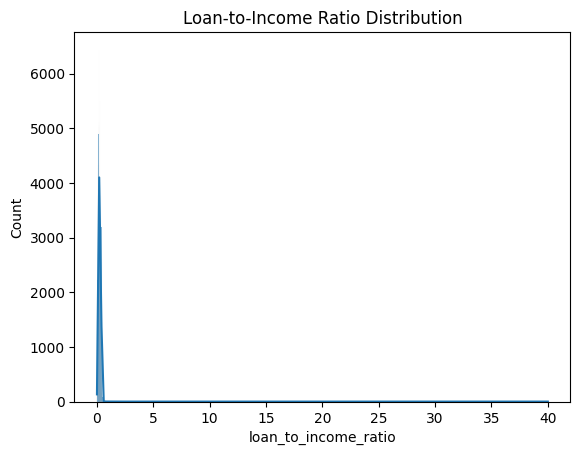

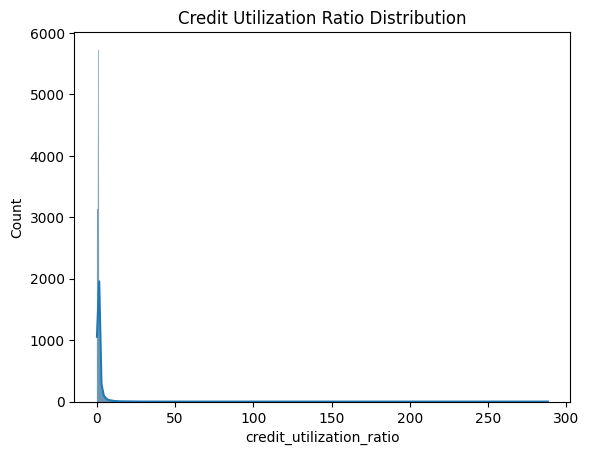

In [ ]:
#Feature Engineering

# Creating new features
loan_data['loan_to_income_ratio'] = loan_data['loan_amnt'] / loan_data['annual_inc']
loan_data['credit_utilization_ratio'] = loan_data['revol_bal'] / loan_data['loan_amnt']

# Check the distributions of new features
sns.histplot(loan_data['loan_to_income_ratio'], kde=True)
plt.title('Loan-to-Income Ratio Distribution')
plt.show()

sns.histplot(loan_data['credit_utilization_ratio'], kde=True)
plt.title('Credit Utilization Ratio Distribution')
plt.show()


In [ ]:
print (loan_data.head())

      issue_d sub_grade        term home_ownership  fico_range_low  total_acc  \
0  2014-01-01        D1   60 months       MORTGAGE           660.0       18.0   
1  2014-01-01        C4   60 months       MORTGAGE           740.0       26.0   
2  2014-01-01        A4   36 months           RENT           700.0       47.0   
3  2014-01-01        D1   60 months       MORTGAGE           665.0       26.0   
4  2014-01-01        C3   36 months       MORTGAGE           700.0       15.0   

   pub_rec  revol_util  annual_inc  int_rate  ...  initial_list_status  \
0      0.0        86.8     40440.0     16.99  ...                    f   
1      0.0       103.5     59000.0     15.61  ...                    f   
2      0.0        11.4     40000.0      7.90  ...                    w   
3      0.0        56.2     70000.0     16.99  ...                    f   
4      1.0        67.1    120000.0     14.98  ...                    f   

  fico_range_high  revol_bal        id open_acc  emp_length loan_sta

In [ ]:

# Categorize FICO score into risk levels
def categorize_fico(fico_score):
    if fico_score >= 800:
        return 'Excellent'
    elif fico_score >= 740:
        return 'Very Good'
    elif fico_score >= 670:
        return 'Good'
    elif fico_score >= 580:
        return 'Fair'
    else:
        return 'Poor'

#  categorization to both 'fico_range_low' and 'fico_range_high'
loan_data['FICO_category'] = loan_data['fico_range_low'].apply(categorize_fico)
loan_data['FICO_category'] = loan_data['fico_range_high'].apply(categorize_fico)

print (loan_data.FICO_category.head())

# Assuming 'term' column has values like '36 months' and '60 months', we can extract the numerical value.
loan_data['term_years'] = loan_data['term'].apply(lambda x: int(x.split()[0]) / 12)


# 6. Binary columns for home ownership
loan_data['home_ownership_OWN'] = loan_data['home_ownership'].apply(lambda x: 1 if x == 'OWN' else 0)
loan_data['home_ownership_RENT'] = loan_data['home_ownership'].apply(lambda x: 1 if x == 'RENT' else 0)
loan_data['home_ownership_MORTGAGE'] = loan_data['home_ownership'].apply(lambda x: 1 if x == 'MORTGAGE' else 0)

# 7. Check if borrower had public records of bankruptcies
loan_data['had_bankruptcy'] = loan_data['pub_rec_bankruptcies'].apply(lambda x: 1 if x > 0 else 0)


0         Fair
1    Very Good
2         Good
3         Fair
4         Good
Name: FICO_category, dtype: object


In [ ]:
print(loan_data[['dti', 'FICO_category', 'term_years', 'home_ownership_OWN', 'home_ownership_RENT', 'loan_to_income_ratio']].head())

     dti FICO_category  term_years  home_ownership_OWN  home_ownership_RENT  \
0  15.16          Fair         5.0                   0                    0   
1  16.74     Very Good         5.0                   0                    0   
2  20.34          Good         3.0                   0                    1   
3  23.15          Fair         5.0                   0                    0   
4  17.88          Good         3.0                   0                    0   

   loan_to_income_ratio  
0              0.439540  
1              0.494492  
2              0.150000  
3              0.222857  
4              0.083333  


In [ ]:
#  macroeconomic features (like interest rates, inflation)  on the 'issue_d' date column
loan_data['issue_d'] = pd.to_datetime(loan_data['issue_d'])
macro_data['date'] = pd.to_datetime(macro_data['date'])

# Merge on 'issue_d' and 'date' columns
merged_data = pd.merge(loan_data, macro_data, left_on='issue_d', right_on='date', how='left')

# Drop the duplicate 'date' column after the merge
merged_data.drop(columns=['date'], inplace=True)

# Check the merged dataset
print(merged_data.head())

     issue_d sub_grade        term home_ownership  fico_range_low  total_acc  \
0 2014-01-01        D1   60 months       MORTGAGE           660.0       18.0   
1 2014-01-01        C4   60 months       MORTGAGE           740.0       26.0   
2 2014-01-01        A4   36 months           RENT           700.0       47.0   
3 2014-01-01        D1   60 months       MORTGAGE           665.0       26.0   
4 2014-01-01        C3   36 months       MORTGAGE           700.0       15.0   

   pub_rec  revol_util  annual_inc  int_rate  ...  loan_to_income_ratio  \
0      0.0        86.8     40440.0     16.99  ...              0.439540   
1      0.0       103.5     59000.0     15.61  ...              0.494492   
2      0.0        11.4     40000.0      7.90  ...              0.150000   
3      0.0        56.2     70000.0     16.99  ...              0.222857   
4      1.0        67.1    120000.0     14.98  ...              0.083333   

  credit_utilization_ratio  FICO_category  term_years home_ownership

In [ ]:

print (merged_data.cpi.head())


0    2.35288
1    2.35288
2    2.35288
3    2.35288
4    2.35288
Name: cpi, dtype: float64


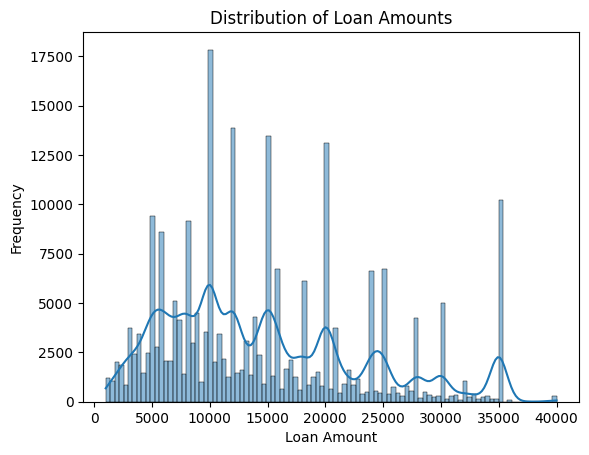

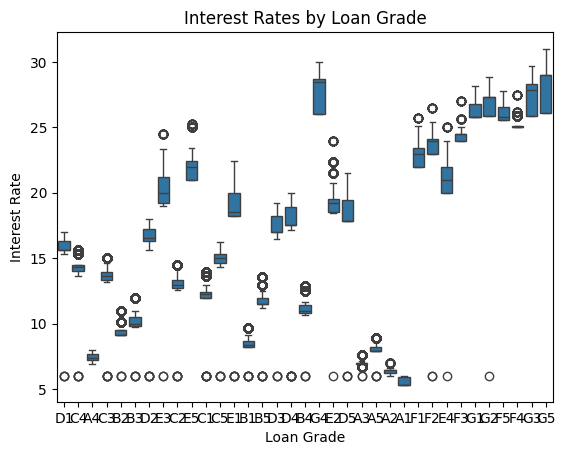

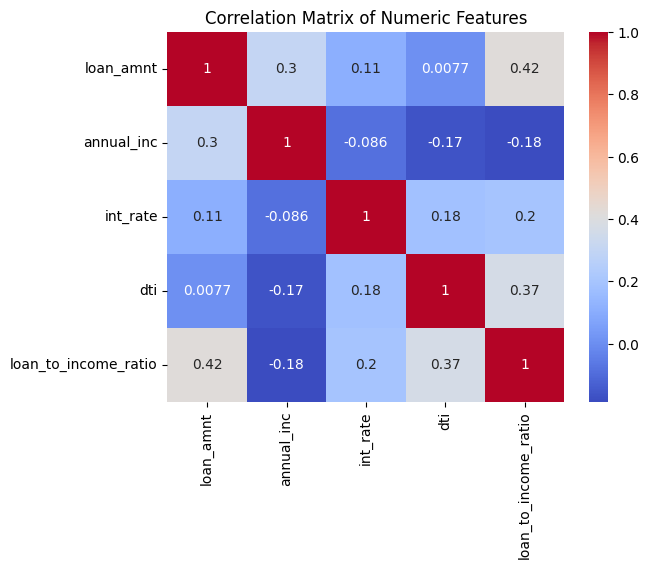

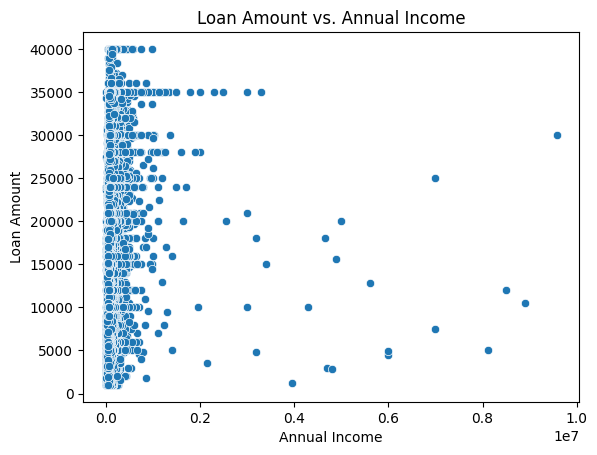

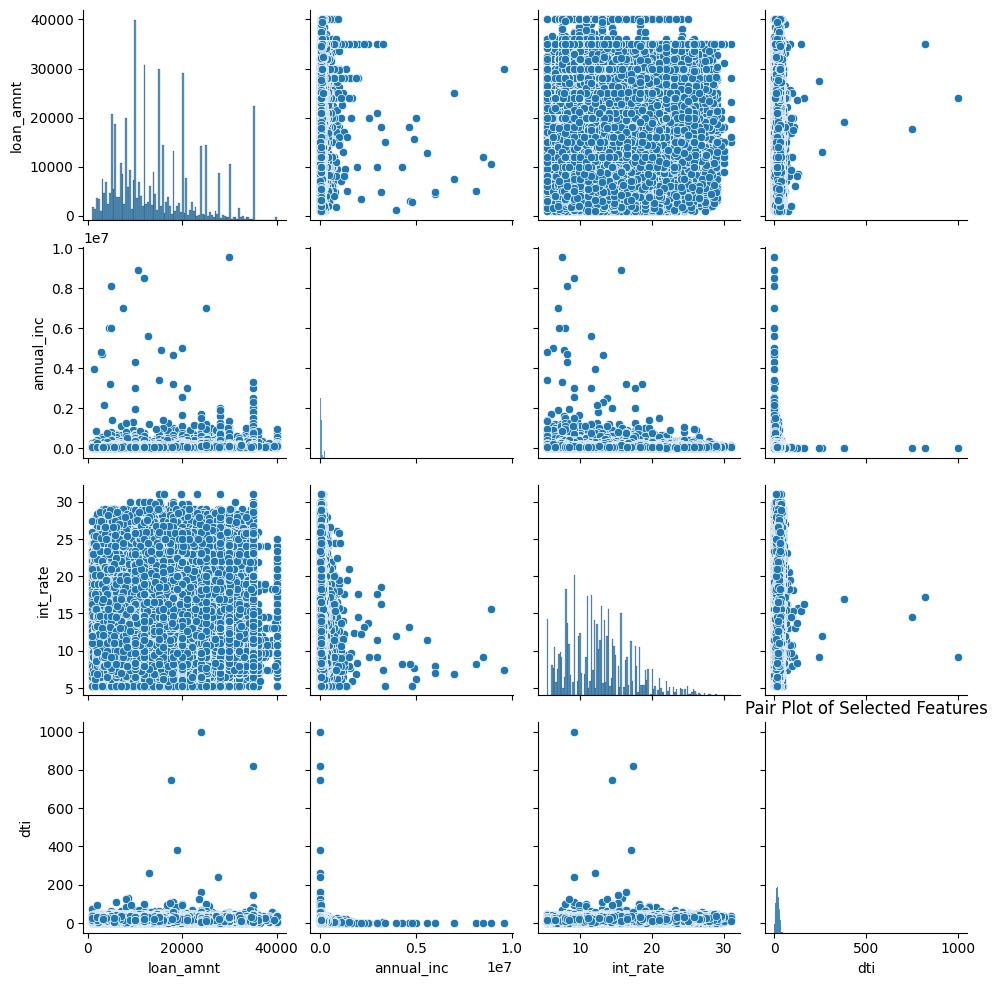

In [ ]:
# Distribution of loan amounts
sns.histplot(merged_data['loan_amnt'], kde=True)
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

# Box plot of interest rates by loan grade
sns.boxplot(x='sub_grade', y='int_rate', data=merged_data)
plt.title('Interest Rates by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate')
plt.show()

# Correlation matrix of numeric features
numeric_features = ['loan_amnt', 'annual_inc', 'int_rate', 'dti', 'loan_to_income_ratio']
correlation_matrix = merged_data[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Scatter plot of loan amount vs. annual income
sns.scatterplot(x='annual_inc', y='loan_amnt', data=merged_data)
plt.title('Loan Amount vs. Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.show()

# Pair plot of selected features
sns.pairplot(merged_data[['loan_amnt', 'annual_inc', 'int_rate', 'dti']])
plt.title('Pair Plot of Selected Features')
plt.show()

In [ ]:
#  real interest rate by subtracting inflation rate from nominal interest rate
merged_data['real_int_rate'] = merged_data['int_rate'] - merged_data['cpi']

#  Adjusted Debt-to-Income Ratio
merged_data['adjusted_dti'] = merged_data['installment'] / merged_data['annual_inc']

In [ ]:

# Check the data types and if there are any missing values
print(merged_data.info())
print(merged_data.isnull().sum())
print (merged_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236846 entries, 0 to 236845
Data columns (total 39 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   issue_d                   236846 non-null  datetime64[ns]
 1   sub_grade                 236846 non-null  object        
 2   term                      236846 non-null  object        
 3   home_ownership            236846 non-null  object        
 4   fico_range_low            236846 non-null  float64       
 5   total_acc                 236846 non-null  float64       
 6   pub_rec                   236846 non-null  float64       
 7   revol_util                236846 non-null  float64       
 8   annual_inc                236846 non-null  float64       
 9   int_rate                  236846 non-null  float64       
 10  dti                       236846 non-null  float64       
 11  purpose                   236846 non-null  object        
 12  mo

In [ ]:

# Identify numeric columns
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

# Identify non-numeric (categorical) columns
categorical_columns = merged_data.select_dtypes(exclude=[np.number]).columns

#fill NaN values with the mean of respective columns
merged_data[numeric_columns] = merged_data[numeric_columns].fillna(merged_data[numeric_columns].mean())

# Handling categorical columns -  using one-hot encoding to fill NaN
merged_data[categorical_columns] = merged_data[categorical_columns].fillna('Unknown')

# Verify that NaN values are handled
print(merged_data.isnull().sum())  # Ensure there are no missing values


issue_d                     0
sub_grade                   0
term                        0
home_ownership              0
fico_range_low              0
total_acc                   0
pub_rec                     0
revol_util                  0
annual_inc                  0
int_rate                    0
dti                         0
purpose                     0
mort_acc                    0
loan_amnt                   0
application_type            0
installment                 0
verification_status         0
pub_rec_bankruptcies        0
addr_state                  0
initial_list_status         0
fico_range_high             0
revol_bal                   0
id                          0
open_acc                    0
emp_length                  0
loan_status                 0
time_to_earliest_cr_line    0
loan_to_income_ratio        0
credit_utilization_ratio    0
FICO_category               0
term_years                  0
home_ownership_OWN          0
home_ownership_RENT         0
home_owner

In [ ]:
# One-hot encode categorical columns for model usage
merged_data_encoded = pd.get_dummies(merged_data, columns=categorical_columns)

# Verify the encoded data
print(merged_data_encoded.head())



   fico_range_low  total_acc  pub_rec  revol_util  annual_inc  int_rate  \
0           660.0       18.0      0.0        86.8     40440.0     16.99   
1           740.0       26.0      0.0       103.5     59000.0     15.61   
2           700.0       47.0      0.0        11.4     40000.0      7.90   
3           665.0       26.0      0.0        56.2     70000.0     16.99   
4           700.0       15.0      1.0        67.1    120000.0     14.98   

     dti  mort_acc  loan_amnt  installment  ...  addr_state_WA  addr_state_WI  \
0  15.16       1.0    17775.0       441.66  ...          False          False   
1  16.74       4.0    29175.0       703.45  ...          False          False   
2  20.34       1.0     6000.0       187.75  ...          False          False   
3  23.15       7.0    15600.0       387.62  ...          False          False   
4  17.88       1.0    10000.0       346.56  ...          False          False   

   addr_state_WV  addr_state_WY  initial_list_status_f  initia

In [ ]:

# Separate numeric and non-numeric columns
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns
non_numeric_columns = merged_data.select_dtypes(exclude=[np.number]).columns

# Replace 'inf' values with NaN in numeric columns only
merged_data[numeric_columns] = merged_data[numeric_columns].replace([np.inf, -np.inf], np.nan)

# Fill NaN values only in numeric columns
merged_data[numeric_columns] = merged_data[numeric_columns].fillna(merged_data[numeric_columns].mean())

#drop rows with NaNs in non-numeric columns if needed
merged_data = merged_data.dropna(subset=non_numeric_columns)

In [ ]:
print(merged_data.int_rate.head())


0    16.99
1    15.61
2     7.90
3    16.99
4    14.98
Name: int_rate, dtype: float64


In [ ]:

# Converting 'term' column to string type first, then removing ' months' and converting to integer
merged_data['term'] = merged_data['term'].astype(str).str.replace(' months', '').astype(int)

# Check the first few rows
print(merged_data['term'].head())
merged_data['real_int_rate'] = merged_data['int_rate'] - merged_data['cpi']

#  Adjusted Debt-to-Income Ratio
merged_data['adjusted_dti'] = merged_data['installment'] / merged_data['annual_inc']


#  features for the model
features = ['loan_amnt', 'annual_inc', 'fico_range_low', 'fico_range_high',
            'revol_bal', 'term_years', 'loan_to_income_ratio',
            'credit_utilization_ratio','real_int_rate',
            'adjusted_dti', 'home_ownership_RENT', 'home_ownership_MORTGAGE',
            'home_ownership_OWN', 'cpi'
           ]


X = merged_data[features]
y = merged_data['int_rate']
# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


0    60
1    60
2    36
3    60
4    36
Name: term, dtype: int64


In [ ]:
 #Replace infinite values with NaN in numeric columns in X_train and X_test
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train[numeric_columns] = X_train[numeric_columns].replace([np.inf, -np.inf], np.nan)
X_test[numeric_columns] = X_test[numeric_columns].replace([np.inf, -np.inf], np.nan)

# Fill NaN values only in numeric columns in X_train and X_test
X_train[numeric_columns] = X_train[numeric_columns].fillna(X_train[numeric_columns].mean())
X_test[numeric_columns] = X_test[numeric_columns].fillna(X_test[numeric_columns].mean())


In [ ]:
#  XGBoost and fit the model

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)


# Predict interest rates on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print(f"XGBoost RMSE: {rmse_xgb}")

#check the first few predictions to see how well they align
print(y_pred_xgb[:5])
print(y_test[:5])

XGBoost RMSE: 0.05626844256866568
[ 5.3219466  6.234319  12.688202   9.170203   9.164484 ]
154367     5.32
128440     6.24
99728     12.69
155550     9.17
210434     9.16
Name: int_rate, dtype: float64


In [ ]:

#  parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

#  XGBoost regressor object
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

#  GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use a suitable scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Display progress
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# the best parameters and score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the model with the best parameters
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.2s
[CV] END

In [ ]:


# Create a DataFrame to compare predicted and actual interest rates
comparison_df = pd.DataFrame({
    'Actual Interest Rate': y_test,
    'Predicted Interest Rate': y_pred_xgb
})

# Show the first few rows
print(comparison_df.tail())


        Actual Interest Rate  Predicted Interest Rate
172204                  7.91                 7.909356
197433                  9.16                 9.162038
223176                 12.99                12.992877
81032                   9.17                 9.165950
173982                 11.99                11.988179


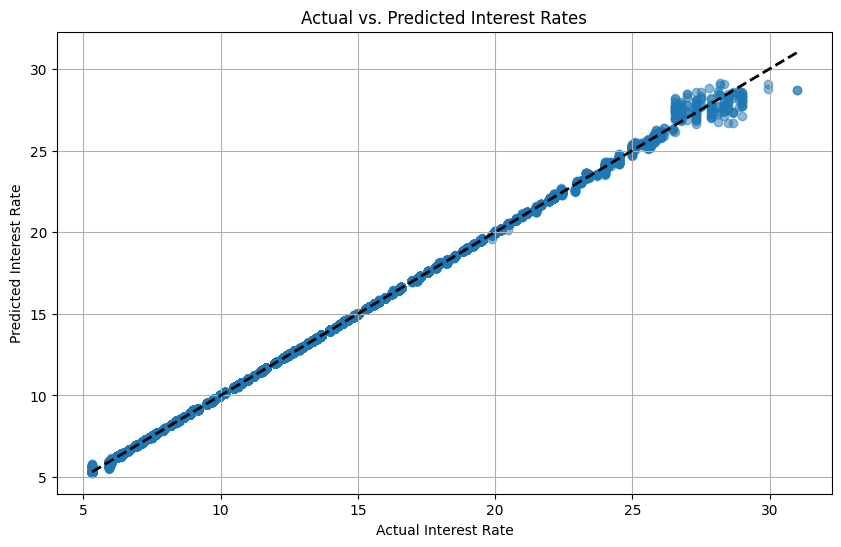

In [81]:

# 'y_test' as actual values and 'y_pred' as predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Interest Rate')
plt.ylabel('Predicted Interest Rate')
plt.title('Actual vs. Predicted Interest Rates')
plt.grid(True)
plt.show()

In [ ]:

# Simulate inflation-adjusted loan pricing
def inflation_adjusted_rate(base_rate, inflation_rate):
    real_rate = base_rate - inflation_rate
    return real_rate

# Apply inflation adjustment to the predicted interest rate
merged_data['inflation_adjusted_rate'] = merged_data.apply(lambda row: inflation_adjusted_rate(row['int_rate'], row['cpi']), axis=1)

# View the adjusted interest rates
print(merged_data[['int_rate', 'cpi', 'inflation_adjusted_rate']].head())


   int_rate      cpi  inflation_adjusted_rate
0     16.99  2.35288                 14.63712
1     15.61  2.35288                 13.25712
2      7.90  2.35288                  5.54712
3     16.99  2.35288                 14.63712
4     14.98  2.35288                 12.62712


In [ ]:
print(merged_data.issue_d.head())



0   2014-01-01
1   2014-01-01
2   2014-01-01
3   2014-01-01
4   2014-01-01
Name: issue_d, dtype: datetime64[ns]


In [86]:
interest_data = merged_data['int_rate']

# Extract the actual interest rate data
interest_data = merged_data['int_rate']
interest_data.index = pd.to_datetime(merged_data['issue_d'])
print(interest_data.head)

interest_data_yearly = interest_data.resample('Y').mean()
interest_data_m = interest_data.resample('M').mean()


<bound method NDFrame.head of issue_d
2014-01-01    16.99
2014-01-01    15.61
2014-01-01     7.90
2014-01-01    16.99
2014-01-01    14.98
              ...  
2015-12-01    12.59
2015-08-01    16.55
2016-02-01     8.39
2016-06-01    13.99
2015-05-01    20.99
Name: int_rate, Length: 236846, dtype: float64>


<ipython-input-86-5c269ce11398>:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  interest_data_yearly = interest_data.resample('Y').mean()
<ipython-input-86-5c269ce11398>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  interest_data_m = interest_data.resample('M').mean()


In [ ]:


# Narrow down the search space
auto_model = auto_arima(
    interest_data,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    max_p=2,  # Limit p
    max_q=2,  # Limit q
    max_order=5  # Total of p+q to limit the complexity
)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1371359.341, Time=100.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1531380.230, Time=5.95 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1463099.206, Time=6.56 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1371360.952, Time=55.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1531378.230, Time=2.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1371364.739, Time=80.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1371347.684, Time=110.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1371356.022, Time=83.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1435524.005, Time=8.49 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1371345.682, Time=32.63 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1371354.019, Time=25.57 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1435522.005, Time=5.39 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1371357.340, Time=31.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1463097.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

DatetimeIndex(['2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', freq='ME')
2016-07-01    18.778033
2016-08-01    16.607624
2016-09-01    15.890542
2016-10-01    14.997287
2016-11-01    14.621222
2016-12-01    14.243611
2017-01-01    14.057592
2017-02-01    13.894627
2017-03-01    13.805550
2017-04-01    13.734135
2017-05-01    13.692297
2017-06-01    13.660655
2017-07-01    13.641239
2017-08-01    13.627111
2017-09-01    13.618169
2017-10-01    13.611828
2017-11-01    13.607730
2017-12-01    13.604873
Freq: MS, Name: predicted_mean, dtype: float64


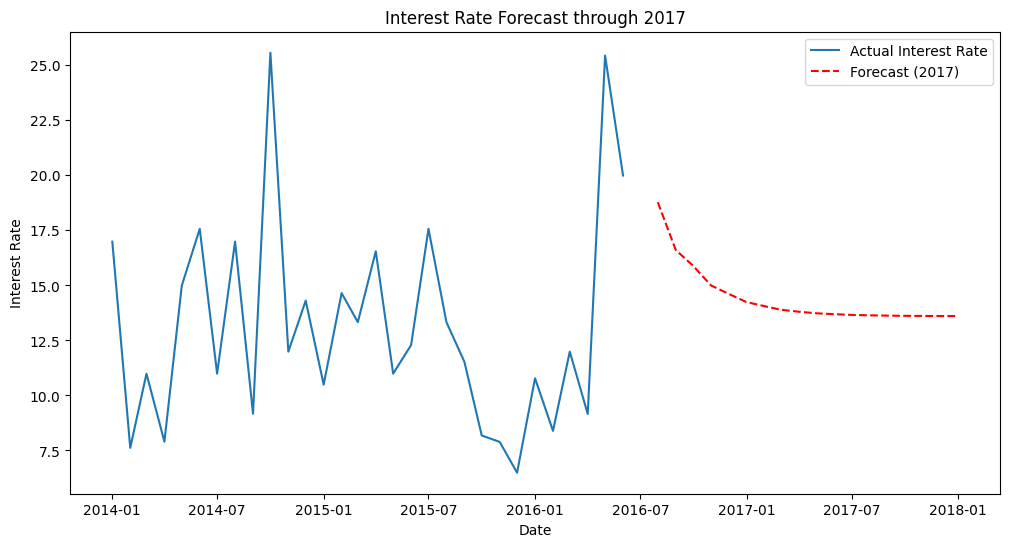

In [92]:

# Fit ARIMA model with the parameters from auto_arima
p, d, q = auto_model.order
arima_model = ARIMA(interest_data, order=(p, d, q))
arima_result = arima_model.fit()

# last date from your historical interest data
last_date = interest_data.index[-1]

# end date for the forecast
forecast_end_date = pd.Timestamp('2017-12-01')

# Calculate the number of months between the last date and forecast end date
forecast_steps = (forecast_end_date.year - last_date.year) * 12 + (forecast_end_date.month - last_date.month)

# Ensure forecast_steps is at least 1 to avoid errors
forecast_steps = max(forecast_steps, 1)

#  forecast
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

# Generate a date range for the forecast that matches forecast_steps
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]

print(forecast_index)
print (forecast_values)

# Plot the historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(interest_data, label='Actual Interest Rate')
plt.plot(forecast_index, forecast_values, label='Forecast (2017)', linestyle='--', color='red')
plt.title('Interest Rate Forecast through 2017')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()


ADF Statistic: -24.521462893592727
p-value: 0.0


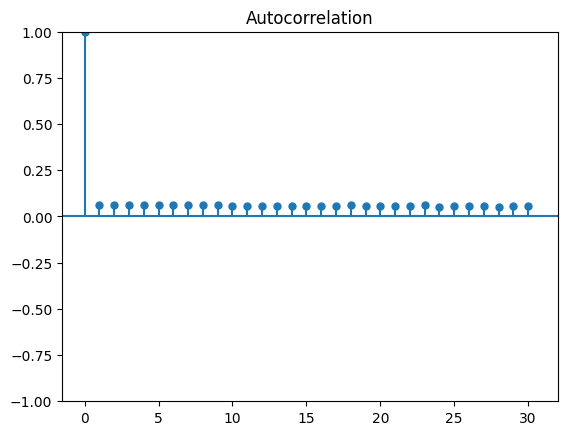

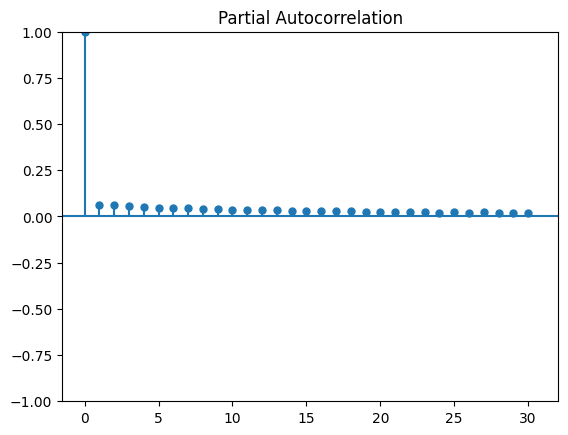

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:               int_rate   No. Observations:               236846
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -685674.010
Date:                Tue, 15 Oct 2024   AIC                        1371354.019
Time:                        21:49:52   BIC                        1371385.145
Sample:                             0   HQIC                       1371363.114
                             - 236846                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0055      0.002      2.694      0.007       0.002       0.010
ma.L1         -0.9880      0.000  -3265.002      0.000      -0.989      -0.987
sigma2        19.1476      0.051    372.495      0.0

In [ ]:

# Checking for stationarity using the Augmented Dickey-Fuller test
adf_result = adfuller(interest_data.dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# ACF and PACF to help choose p and q
plot_acf(interest_data.dropna(), lags=30)
plot_pacf(interest_data.dropna(), lags=30)
plt.show()

# Fit the ARIMA model with chosen parameters
arima_model = ARIMA(interest_data, order=(1, 1, 1))
arima_result = arima_model.fit()

# Print model summary
print(arima_result.summary())


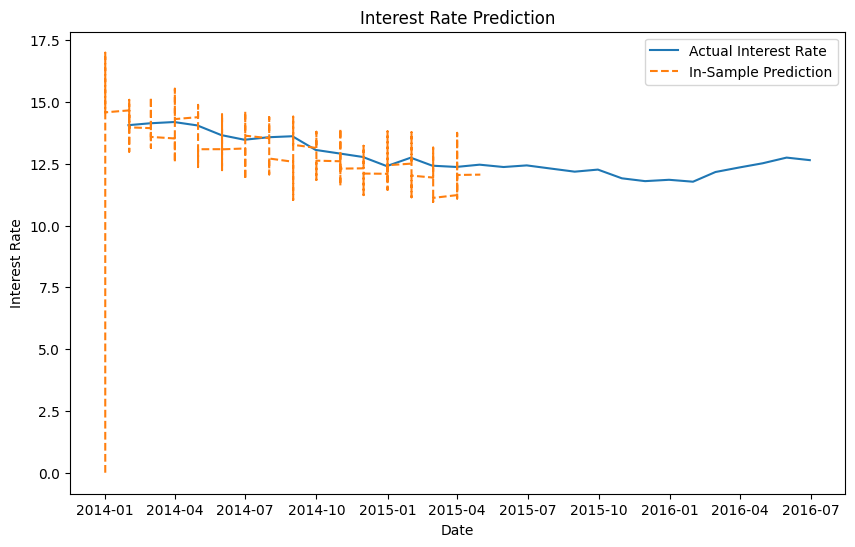

issue_d
2014-01-01     0.000000
2014-01-01    16.989680
2014-01-01    16.300492
2014-01-01    13.481965
2014-01-01    14.351135
Name: predicted_mean, dtype: float64


In [89]:
# Generate in-sample predictions
start_date = interest_data.index[0]
end_date = interest_data.index[-1]
in_sample_pred = arima_result.predict(start=start_date, end=end_date, typ='levels')

# actual data and predictions
plt.figure(figsize=(10, 6))
plt.plot(interest_data_m, label='Actual Interest Rate')
plt.plot(in_sample_pred, label='In-Sample Prediction', linestyle='--')
plt.title('Interest Rate Prediction')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()

print(in_sample_pred.head())


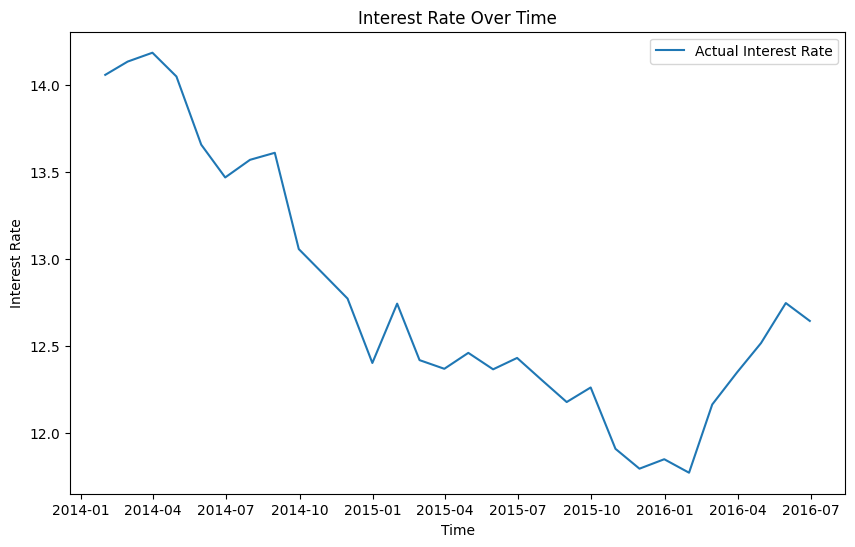

In [87]:

#plotting data to check for seasonality/trend
plt.figure(figsize=(10, 6))
plt.plot(interest_data_m, label='Actual Interest Rate')
plt.title('Interest Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


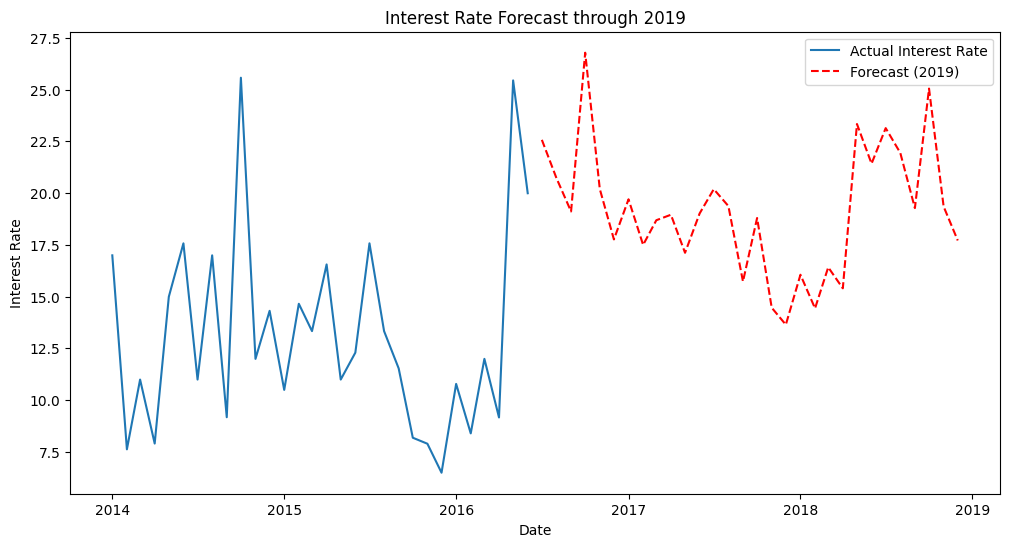

In [94]:


# Drop duplicates in the 'issue_d' column, keeping the first
merged_data = merged_data.drop_duplicates(subset='issue_d')

# 'issue_d' is in datetime format
merged_data['issue_d'] = pd.to_datetime(merged_data['issue_d'])

# 'issue_d' as the index for interest_data and exog_data
interest_data = merged_data.set_index('issue_d')['int_rate']
exog_data = merged_data.set_index('issue_d')[['cpi']]

# Fit a SARIMA model without exogenous variables
# SARIMA order (p, d, q) and seasonal order (P, D, Q, S)
p, d, q = 1, 1, 1  # ARIMA parameters
P, D, Q, S = 1, 1, 1, 12  # Seasonal parameters

sarima_model = SARIMAX(interest_data, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_result = sarima_model.fit()

# Forecast for a specific period
forecast_end_date = pd.Timestamp('2018-12-01')
last_date = interest_data.index[-1]
forecast_steps = (forecast_end_date.year - last_date.year) * 12 + (forecast_end_date.month - last_date.month)
forecast_steps = max(forecast_steps, 1)  # Ensure at least one step for the forecast

# forecast
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean



# results
plt.figure(figsize=(12, 6))
plt.plot(interest_data, label='Actual Interest Rate')
plt.plot(forecast_values.index, forecast_values, label='Forecast (2019)', linestyle='--', color='red')
plt.title('Interest Rate Forecast through 2019')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()
